# ASR Assignment 2022-23

This notebook has been provided as a template to get you started on the assignment.  Feel free to use it for your development, or do your development directly in Python.

You can find a full description of the assignment [here](http://www.inf.ed.ac.uk/teaching/courses/asr/2022-23/coursework.pdf).

You are provided with two Python modules `observation_model.py` and `wer.py`.  The first was described in [Lab 3](https://github.com/ZhaoZeyu1995/asr_labs/blob/master/asr_lab3_4.ipynb).  The second can be used to compute the number of substitution, deletion and insertion errors between ASR output and a reference text.

It can be used as follows:

```python
import wer

my_refence = 'A B C'
my_output = 'A C C D'

wer.compute_alignment_errors(my_reference, my_output)
```

This produces a tuple $(s,d,i)$ giving counts of substitution,
deletion and insertion errors respectively - in this example (1, 0, 1).  The function accepts either two strings, as in the example above, or two lists.  Matching is case sensitive.

## Template code

Assuming that you have already made a function to generate an WFST, `create_wfst()` and a decoder class, `MyViterbiDecoder`, you can perform recognition on all the audio files as follows:


## ViterbiDecoder

In [1]:
import observation_model
import math
import openfst_python as fst

class MyViterbiDecoder:
    
    NLL_ZERO = 1e10  # define a constant representing -log(0).  This is really infinite, but approximate
                     # it here with a very large number
    
    def __init__(self, f, audio_file_name):
        """Set up the decoder class with an audio file and WFST f
        """
        self.om = observation_model.ObservationModel()
        self.f = f
        self.forward_computations = 0 # initialize count (computing probability)
        
        if audio_file_name:
            self.om.load_audio(audio_file_name)
        else:
            self.om.load_dummy_audio()
        
        self.initialise_decoding()

        
    def initialise_decoding(self):
        """set up the values for V_j(0) (as negative log-likelihoods)
        
        """
        
        self.V = []   # stores likelihood along best path reaching state j
        self.B = []   # stores identity of best previous state reaching state j
        self.W = []   # stores output labels sequence along arc reaching j - this removes need for 
                      # extra code to read the output sequence along the best path
            
        self.forward_computations = 0 # initialize count (computing probability)
        
        for t in range(self.om.observation_length()+1):
            self.V.append([self.NLL_ZERO]*self.f.num_states())
            self.B.append([-1]*self.f.num_states())
            self.W.append([[] for i in range(self.f.num_states())])  #  multiplying the empty list doesn't make multiple
        
        # The above code means that self.V[t][j] for t = 0, ... T gives the Viterbi cost
        # of state j, time t (in negative log-likelihood form)
        # Initialising the costs to NLL_ZERO effectively means zero probability    
        
        # give the WFST start state a probability of 1.0   (NLL = 0.0)
        self.V[0][self.f.start()] = 0.0
        
        # some WFSTs might have arcs with epsilon on the input (you might have already created 
        # examples of these in earlier labs) these correspond to non-emitting states, 
        # which means that we need to process them without stepping forward in time.  
        # Don't worry too much about this!  
        self.traverse_epsilon_arcs(0)        
        
    def traverse_epsilon_arcs(self, t):
        """Traverse arcs with <eps> on the input at time t
        
        These correspond to transitions that don't emit an observation
        
        We've implemented this function for you as it's slightly trickier than
        the normal case.  You might like to look at it to see what's going on, but
        don't worry if you can't fully follow it.
        
        """
        
        states_to_traverse = list(self.f.states()) # traverse all states
        while states_to_traverse:
            
            # Set i to the ID of the current state, the first 
            # item in the list (and remove it from the list)
            i = states_to_traverse.pop(0)   
        
            # don't bother traversing states which have zero probability
            if self.V[t][i] == self.NLL_ZERO:
                    continue
        
            for arc in self.f.arcs(i):
                
                if arc.ilabel == 0:     # if <eps> transition
                  
                    j = arc.nextstate   # ID of next state  
                
                    if self.V[t][j] > self.V[t][i] + float(arc.weight):
                        # computing the likelihood(float(arc.weight)) along an arc, count+1
                        self.forward_computations += 1
                        
                        # this means we've found a lower-cost path to
                        # state j at time t.  We might need to add it
                        # back to the processing queue.
                        self.V[t][j] = self.V[t][i] + float(arc.weight)
                        
                        # save backtrace information.  In the case of an epsilon transition, 
                        # we save the identity of the best state at t-1.  This means we may not
                        # be able to fully recover the best path, but to do otherwise would
                        # require a more complicated way of storing backtrace information
                        self.B[t][j] = self.B[t][i] 
                        
                        # and save the output labels encountered - this is a list, because
                        # there could be multiple output labels (in the case of <eps> arcs)
                        if arc.olabel != 0:
                            self.W[t][j] = self.W[t][i] + [arc.olabel]
                        else:
                            self.W[t][j] = self.W[t][i]
                        
                        if j not in states_to_traverse:
                            states_to_traverse.append(j)

    
    def forward_step(self, t):
          
        for i in self.f.states():
            
            if not self.V[t-1][i] == self.NLL_ZERO:   # no point in propagating states with zero probability
                
                for arc in self.f.arcs(i):
                    
                    if arc.ilabel != 0: # <eps> transitions don't emit an observation
                        j = arc.nextstate
                        tp = float(arc.weight)  # transition prob
                        self.forward_computations += 1  # computing the likelihood(tp) along an arc, count+1
                        ep = -self.om.log_observation_probability(self.f.input_symbols().find(arc.ilabel), t)  # emission negative log prob
                        prob = tp + ep + self.V[t-1][i] # they're logs
                        if prob < self.V[t][j]:
                            self.V[t][j] = prob
                            self.B[t][j] = i
                            
                            # store the output labels encountered too
                            if arc.olabel !=0:
                                self.W[t][j] = [arc.olabel]
                            else:
                                self.W[t][j] = []
                            
    
    def finalise_decoding(self):
        """ this incorporates the probability of terminating at each state
        """
        
        for state in self.f.states():
            final_weight = float(self.f.final(state))
            if self.V[-1][state] != self.NLL_ZERO:
                if final_weight == math.inf:
                    self.V[-1][state] = self.NLL_ZERO  # effectively says that we can't end in this state
                else:
                    self.V[-1][state] += final_weight
                    
        # get a list of all states where there was a path ending with non-zero probability
        finished = [x for x in self.V[-1] if x < self.NLL_ZERO]
        if not finished:  # if empty
            print("No path got to the end of the observations.")
        
        
    def decode(self):
        self.initialise_decoding()
        t = 1
        while t <= self.om.observation_length():
            self.forward_step(t)
            self.traverse_epsilon_arcs(t)
            t += 1
        self.finalise_decoding()
    
    def backtrace(self):  
        best_final_state = self.V[-1].index(min(self.V[-1])) # argmin
        best_state_sequence = [best_final_state]
        best_out_sequence = []
        
        t = self.om.observation_length()   # ie T
        j = best_final_state
        
        while t >= 0:
            i = self.B[t][j]
            best_state_sequence.append(i)
            best_out_sequence = self.W[t][j] + best_out_sequence  # computer scientists might like
                                                                                # to make this more efficient!

            # continue the backtrace at state i, time t-1
            j = i  
            t-=1
            
        best_state_sequence.reverse()
        
        # convert the best output sequence from FST integer labels into strings
        best_out_sequence = ' '.join([self.f.output_symbols().find(label) for label in best_out_sequence])
        
        return (best_state_sequence, best_out_sequence)
    
    def count_memory(self):
        # count the number of states and arcs in this decoder
        state_count = 0
        arc_count = 0
        for state in self.f.states():
            state_count += 1
            for arc in self.f.arcs(state):
                arc_count += 1
        return state_count, arc_count

## vocabulary processing

In [2]:
def parse_lexicon(lex_file):
    """
    Parse the lexicon file and return it in dictionary form.
    
    Args:
        lex_file (str): filename of lexicon file with structure '<word> <phone1> <phone2>...'
                        eg. peppers p eh p er z

    Returns:
        lex (dict): dictionary mapping words to list of phones
    """
    
    lex = {}  # create a dictionary for the lexicon entries (this could be a problem with larger lexica)
    with open(lex_file, 'r') as f:
        for line in f:
            line = line.split()  # split at each space
            lex[line[0]] = line[1:]  # first field the word, the rest is the phones
    return lex

def generate_symbol_tables(lexicon, n=3):
    '''
    Return word, phone and state symbol tables based on the supplied lexicon
        
    Args:
        lexicon (dict): lexicon to use, created from the parse_lexicon() function
        n (int): number of states for each phone HMM
        
    Returns:
        word_table (fst.SymbolTable): table of words
        phone_table (fst.SymbolTable): table of phones
        state_table (fst.SymbolTable): table of HMM phone-state IDs
    '''
    
    state_table = fst.SymbolTable()
    phone_table = fst.SymbolTable()
    word_table = fst.SymbolTable()
    
    # add empty <eps> symbol to all tables
    state_table.add_symbol('<eps>')
    phone_table.add_symbol('<eps>')
    word_table.add_symbol('<eps>')
    
    for word, phones  in lexicon.items():
        
        word_table.add_symbol(word)
        
        for p in phones: # for each phone
            
            phone_table.add_symbol(p)
            for i in range(1,n+1): # for each state 1 to n
                state_table.add_symbol('{}_{}'.format(p, i))
            
    return word_table, phone_table, state_table

# #test
# lex = parse_lexicon('lexicon.txt')
# word_table, phone_table, state_table = generate_symbol_tables(lex)
# lex

## basic WFSTs

In [3]:
def generate_phone_wfst(f, start_state, weights, phone, n, phone_count, phone_number, word):
    """
    Generate a WFST representating an n-state left-to-right phone HMM
    
    Args:
        f (fst.Fst()): an FST object, assumed to exist already
        start_state (int): the index of the first state, assmed to exist already
        weights: weights for self-loop and transfer to next_state
        phone (str): the phone label 
        n (int): number of states for each phone HMM
        phone_count: number of phone generated word
        phone_number: number of phones for word
        word: the word (in the lexion) that we want to recognize
    Returns:
        the final state of the FST
    """   
    current_state = start_state
    
    for i in range(1, n+1):
        
        in_label = state_table.find('{}_{}'.format(phone, i))
        
        sl_weight = fst.Weight('log', -math.log(weights['self-loop']))  # weight for self-loop
        # self-loop back to current state
        f.add_arc(current_state, fst.Arc(in_label, 0, sl_weight, current_state))
        
        # transition to next state
        if i == n and phone_count == phone_number:
            #if this is the final phone in a word, output this word
            in_label  = 0 # from <eps> output word
            out_label = word_table.find(word)  # output word label at the final phone_state of this word
        else:
            out_label = 0   # output empty <eps> label
            
        next_state = f.add_state()
        next_weight = fst.Weight('log', -math.log(weights['next'])) # weight to next state
        f.add_arc(current_state, fst.Arc(in_label, out_label, next_weight, next_state))    
       
        current_state = next_state
        
    return current_state

def generate_sequence_wfst(n=3, uniform=True, weights={'self-loop':0.1, 'next':0.9}):
    """ Generate a WFST for any sequence in the lexicon, composed of n-state phone WFSTs.
    Args:
        n: phone-states(#n state for each phone)
        uniform: whether transfer uniformly from the start state to words
        weights: weights for self-loop and transfer to next_state
    Returns:
        the constructed WFST
    """
    f = fst.Fst('log')
    # create the start state
    start_state = f.add_state()
    f.set_start(start_state)
    if uniform:  # transfer from start state to each word uniformly
        start_weight = fst.Weight('log', -math.log(1 / len(lex.keys())))
    
    for word, phones in lex.items():
        current_state = f.add_state()
        # transfer from start state to each word with start_weight
        f.add_arc(start_state, fst.Arc(0, 0, start_weight, current_state))
        
        # initialize counting
        phone_count = 1
        phone_number = len(phones)
        
        for phone in phones: 
            current_state = generate_phone_wfst(f, current_state, weights, phone, n, phone_count, phone_number, word)
            phone_count += 1
        
        f.set_final(current_state)
        # transfer to start state with probability 1
        f.add_arc(current_state, fst.Arc(0, 0, fst.Weight('log', -math.log(1)), start_state))
        
    return f

## read and evaluate

In [15]:
from tqdm import tqdm_notebook as tqdm
import time

def read_transcription(wav_file):
    """
    Get the transcription corresponding to wav_file.
    """
    
    transcription_file = os.path.splitext(wav_file)[0] + '.txt'
    
    with open(transcription_file, 'r') as f:
        transcription = f.readline().strip()
    
    return transcription

def evaluate(f, show=False):
    """evaluate given f(WFST) according to the
        WER on the whole documents, 
        RUNNING TIME and forward computations for Viterbi decoding, 
        MEMORY require for decoder (based on the number of states and arcs)
    Args:
        f: f (fst.Fst()): a WFST object, assumed to exist already
        count: if show is true, we will count the overall number operations implemented when computing WER,
        and show the first 5 paths of phone states
    Returns:
        return a metric dictionary
    """
    error_all = 0
    word_counts = 0
    if show:
        # count WER operations
        num_s = 0
        num_d = 0
        num_i = 0
        count = 0
        path_record = []
        print('the number of substitutions, deletions, insertions:', num_s, ';', num_d, ';', num_i)
    
    
    # initilize metrics
    wer_final = 0.0
    running_time = 0.0
    computation_count = 0
    state_count = 0
    arc_count = 0
    
    #progress bars
    totals = len(glob.glob('/group/teaching/asr/labs/recordings/*.wav'))
    pbar = tqdm(total=totals)
    
    # time count
    start_time = time.time()
    for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
                                                                               # audio files
        transcription = read_transcription(wav_file)

        decoder = MyViterbiDecoder(f, wav_file)

        decoder.decode()
        (state_path, words) = decoder.backtrace()

        # WER 
        error_counts = wer.compute_alignment_errors(transcription, words)
        word_count = len(transcription.split())
        
        error_all += sum(error_counts) 
        word_counts += word_count
        
        # WER operations
        if show:
            num_s += error_counts[0]
            num_d += error_counts[1]
            num_i += error_counts[2]
            if count <= 5:
                path_record.append([phone_table.find(idx) for idx in state_path])
                count += 1
        
        # forward computations
        computation_count += decoder.forward_computations
        
        pbar.update(1)
    #print(word_counts)
    
    # final WER   
    wer_final = error_all/word_counts
    # MEMORY
    state_count, arc_count = decoder.count_memory()
    # RUNNING TIME
    end_time = time.time()
    running_time = end_time - start_time
    
    # show WER operations:
    if show:
        print('the number of substitutions, deletions, insertions:', num_s, ';', num_d, ';', num_i)
        print(path_record)
    
    # save metrics
    metrics = {'WER': wer_final,
                'RUNNING_TIME': running_time,
                'number_of_computations': computation_count,
                'number_of_states': state_count,
                'number_of_arcs': arc_count
              }
    return metrics

# Task 1

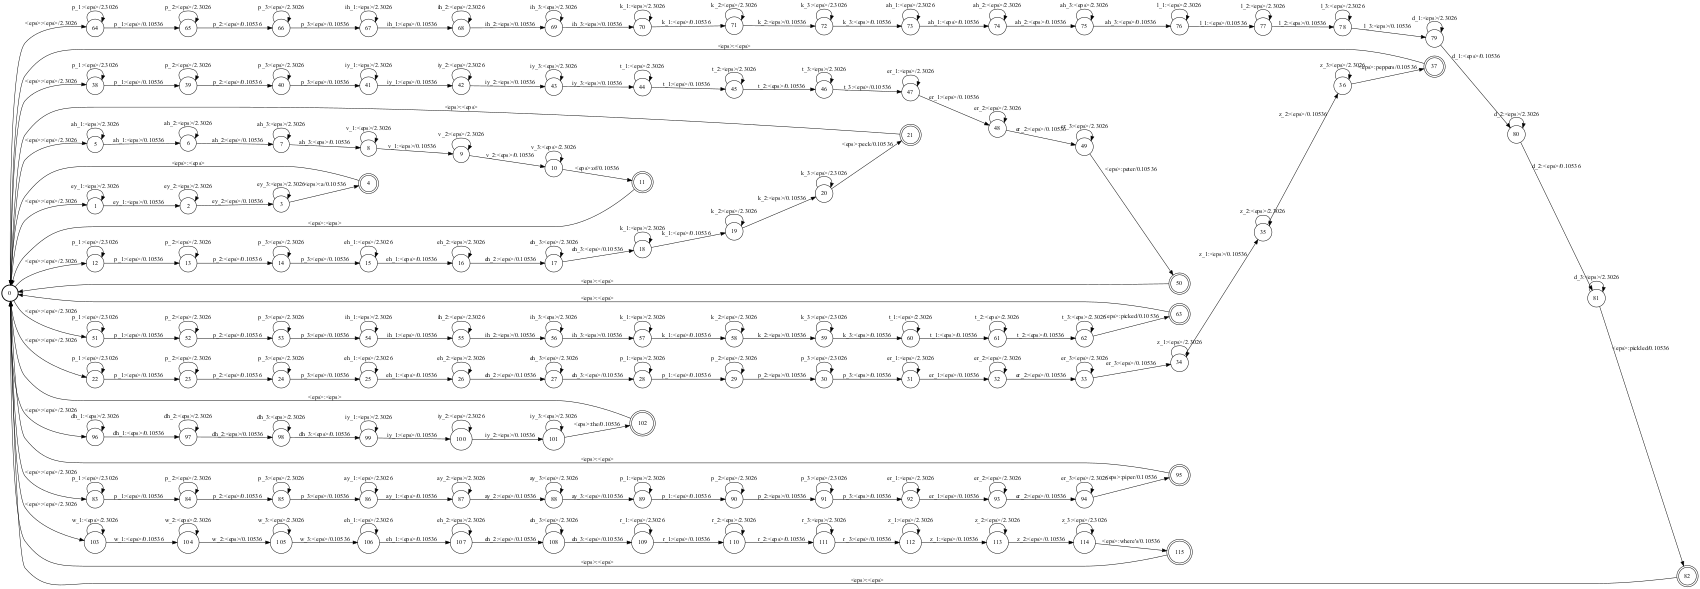

In [16]:
import glob
import os
import wer
import observation_model
import openfst_python as fst

#build vocabulary
lex = parse_lexicon('lexicon.txt')
word_table, phone_table, state_table = generate_symbol_tables(lex)

#build baseline WFST to recognise every possible sequence of words in Vocabulary(V)
baseline = generate_sequence_wfst(n=3, uniform=True, weights={'self-loop':0.1, 'next':0.9})
baseline.set_input_symbols(state_table)
baseline.set_output_symbols(word_table)

####visiualization
from subprocess import check_call
from IPython.display import Image
baseline.draw('tmp.dot', portrait=True)
check_call(['dot','-Tpng','-Gdpi=200','tmp.dot','-o','tmp.png'])
Image(filename='tmp.png')

In [17]:
#count average length
words_count = 0
char_count = 0
doc_counts = len(glob.glob('/group/teaching/asr/labs/recordings/*.wav'))
for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
                                                                          # audio files
    transcription = read_transcription(wav_file)
    words = transcription.split()
    words_count += len(words)
    char_count += sum([len(word) for word in words])
    #print(transcription)
print('The number of documents:',doc_counts,
      '\n','The number of all words:', words_count,
      '\n','The average number of char per word:', char_count/words_count,
     )

The number of documents: 318 
 The number of all words: 2434 
 The average number of char per word: 4.947000821692687


In [21]:
#evaluation
baseline_metrics = evaluate(baseline, show=True)
baseline_metrics
#the number of substitutions, deletions, insertions: 671 ; 15 ; 3195

the number of substitutions, deletions, insertions: 0 ; 0 ; 0


/afs/inf.ed.ac.uk/user/s18/s1899254/.conda/envs/asr_env/lib/python3.7/site-packages/ipykernel_launcher.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/318 [00:00<?, ?it/s]

the number of substitutions, deletions, insertions: 671 ; 15 ; 3195
[[-1, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 100, 5, 5, 5, 5, 6, 7, 8, 8, 8, 8, 9, 10, 10, 10, 10, 10, 10, 64, 65, 66, 67, 67, 67, 68, 68, 69, 69, 69, 70, 70, 70, 70, 71, 71, 72, 72, 72, 73, 74, 75, 76, 76, 76, 77, 78, 78, 79, 79, 79, 80, 81, 81, 81, 81, 81, 81, 81, 83, 84, 84, 85, 86, 86, 86, 86, 86, 87, 87, 87, 88, 88, 88, 88, 88, 88, 89, 90, 91, 92, 93, 96, 96, 97, 97, 98, 98, 99, 100, 5, 6, 6, 6, 6, 6, 6, 6, 7, 8, 8, 8, 8, 8, 8, 9, 10, 10, 10, 10, 10, 10, 10, 38, 38, 38, 39, 39, 39, 40, 40, 41, 41, 41, 41, 42, 42, 42, 43, 43, 44, 45, 45, 46, 46,

{'WER': 1.5944946589975348,
 'RUNNING_TIME': 1191.1577415466309,
 'number_of_computations': 34224910,
 'number_of_states': 116,
 'number_of_arcs': 230}

# Task 2

## sl and next weights

In [89]:
#build baseline WFST to recognise every possible sequence of words in Vocabulary(V)
baseline_28 = generate_sequence_wfst(n=3, uniform=True, weights={'self-loop':0.2, 'next':0.8})
baseline_28.set_input_symbols(state_table)
baseline_28.set_output_symbols(word_table)

print('model with weights={self-loop:0.2, transfer to next:0.8}')
#evaluation
baseline_metrics = evaluate(baseline_28)
baseline_metrics

model with weights={self-loop:0.2, transfer to next:0.8}


/afs/inf.ed.ac.uk/user/s18/s1899254/.conda/envs/asr_env/lib/python3.7/site-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/318 [00:00<?, ?it/s]

{'WER': 1.061216105176664,
 'RUNNING_TIME': 974.8214678764343,
 'number_of_computations': 34159889,
 'number_of_states': 116,
 'number_of_arcs': 230}

In [7]:
#build baseline WFST to recognise every possible sequence of words in Vocabulary(V)
baseline_37 = generate_sequence_wfst(n=3, uniform=True, weights={'self-loop':0.3, 'next':0.7})
baseline_37.set_input_symbols(state_table)
baseline_37.set_output_symbols(word_table)

print('model with weights={self-loop:0.3, transfer to next:0.7}')
#evaluation
baseline_metrics = evaluate(baseline_37)
baseline_metrics

model with weights={self-loop:0.3, transfer to next:0.7}


/afs/inf.ed.ac.uk/user/s18/s1899254/.conda/envs/asr_env/lib/python3.7/site-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/318 [00:00<?, ?it/s]

{'WER': 0.9260476581758422,
 'RUNNING_TIME': 971.9977700710297,
 'number_of_computations': 34129634,
 'number_of_states': 116,
 'number_of_arcs': 230}

In [8]:
#build baseline WFST to recognise every possible sequence of words in Vocabulary(V)
baseline_46 = generate_sequence_wfst(n=3, uniform=True, weights={'self-loop':0.4, 'next':0.6})
baseline_46.set_input_symbols(state_table)
baseline_46.set_output_symbols(word_table)

print('model with weights={self-loop:0.4, transfer to next:0.6}')
#evaluation
baseline_metrics = evaluate(baseline_46)
baseline_metrics

model with weights={self-loop:0.4, transfer to next:0.6}


/afs/inf.ed.ac.uk/user/s18/s1899254/.conda/envs/asr_env/lib/python3.7/site-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/318 [00:00<?, ?it/s]

{'WER': 0.8582580115036976,
 'RUNNING_TIME': 985.2350106239319,
 'number_of_computations': 34108888,
 'number_of_states': 116,
 'number_of_arcs': 230}

In [9]:
#build baseline WFST to recognise every possible sequence of words in Vocabulary(V)
baseline_55 = generate_sequence_wfst(n=3, uniform=True, weights={'self-loop':0.5, 'next':0.5})
baseline_55.set_input_symbols(state_table)
baseline_55.set_output_symbols(word_table)

print('model with weights={self-loop:0.5, transfer to next:0.5}')
#evaluation
baseline_metrics = evaluate(baseline_55)
baseline_metrics

model with weights={self-loop:0.5, transfer to next:0.5}


/afs/inf.ed.ac.uk/user/s18/s1899254/.conda/envs/asr_env/lib/python3.7/site-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/318 [00:00<?, ?it/s]

{'WER': 0.8147082990961381,
 'RUNNING_TIME': 969.958803653717,
 'number_of_computations': 34090788,
 'number_of_states': 116,
 'number_of_arcs': 230}

In [10]:
#build baseline WFST to recognise every possible sequence of words in Vocabulary(V)
baseline_64 = generate_sequence_wfst(n=3, uniform=True, weights={'self-loop':0.6, 'next':0.4})
baseline_64.set_input_symbols(state_table)
baseline_64.set_output_symbols(word_table)

print('model with weights={self-loop:0.6, transfer to next:0.4}')
#evaluation
baseline_metrics = evaluate(baseline_64)
baseline_metrics

model with weights={self-loop:0.6, transfer to next:0.4}


/afs/inf.ed.ac.uk/user/s18/s1899254/.conda/envs/asr_env/lib/python3.7/site-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/318 [00:00<?, ?it/s]

{'WER': 0.7777321281840591,
 'RUNNING_TIME': 978.3053770065308,
 'number_of_computations': 34074892,
 'number_of_states': 116,
 'number_of_arcs': 230}

In [6]:
#build baseline WFST to recognise every possible sequence of words in Vocabulary(V)
baseline_73 = generate_sequence_wfst(n=3, uniform=True, weights={'self-loop':0.7, 'next':0.3})
baseline_73.set_input_symbols(state_table)
baseline_73.set_output_symbols(word_table)

print('model with weights={self-loop:0.7, transfer to next:0.3}')
#evaluation
baseline_metrics = evaluate(baseline_73)
baseline_metrics

model with weights={self-loop:0.7, transfer to next:0.3}


/afs/inf.ed.ac.uk/user/s18/s1899254/.conda/envs/asr_env/lib/python3.7/site-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/318 [00:00<?, ?it/s]

{'WER': 0.7510271158586689,
 'RUNNING_TIME': 1037.3484358787537,
 'number_of_computations': 34058223,
 'number_of_states': 116,
 'number_of_arcs': 230}

In [7]:
#build baseline WFST to recognise every possible sequence of words in Vocabulary(V)
baseline_82 = generate_sequence_wfst(n=3, uniform=True, weights={'self-loop':0.8, 'next':0.2})
baseline_82.set_input_symbols(state_table)
baseline_82.set_output_symbols(word_table)

print('model with weights={self-loop:0.8, transfer to next:0.2}')
#evaluation
baseline_metrics = evaluate(baseline_82)
baseline_metrics

model with weights={self-loop:0.8, transfer to next:0.2}


/afs/inf.ed.ac.uk/user/s18/s1899254/.conda/envs/asr_env/lib/python3.7/site-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/318 [00:00<?, ?it/s]

{'WER': 0.7271980279375514,
 'RUNNING_TIME': 1028.5963156223297,
 'number_of_computations': 34038275,
 'number_of_states': 116,
 'number_of_arcs': 230}

In [8]:
#build baseline WFST to recognise every possible sequence of words in Vocabulary(V)
baseline_91 = generate_sequence_wfst(n=3, uniform=True, weights={'self-loop':0.9, 'next':0.1})
baseline_91.set_input_symbols(state_table)
baseline_91.set_output_symbols(word_table)

print('model with weights={self-loop:0.9, transfer to next:0.1}')
#evaluation
baseline_metrics = evaluate(baseline_91)
baseline_metrics

model with weights={self-loop:0.9, transfer to next:0.1}


/afs/inf.ed.ac.uk/user/s18/s1899254/.conda/envs/asr_env/lib/python3.7/site-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/318 [00:00<?, ?it/s]

{'WER': 0.6914543960558751,
 'RUNNING_TIME': 1025.4549293518066,
 'number_of_computations': 34010185,
 'number_of_states': 116,
 'number_of_arcs': 230}

In [22]:
#build baseline WFST to recognise every possible sequence of words in Vocabulary(V)
baseline_10 = generate_sequence_wfst(n=3, uniform=True, weights={'self-loop':0.99, 'next':0.01})
baseline_10.set_input_symbols(state_table)
baseline_10.set_output_symbols(word_table)

print('model with weights={self-loop:0.99, transfer to next:0.01}')
#evaluation
baseline_metrics = evaluate(baseline_10, show=True)
baseline_metrics

# {'WER': 0.6433853738701726,
#  'RUNNING_TIME': 1032.6230416297913,
#  'number_of_computations': 33933128,
#  'number_of_states': 116,
#  'number_of_arcs': 230}
# the number of substitutions, deletions, insertions: 677 ; 252 ; 637

model with weights={self-loop:0.99, transfer to next:0.01}
the number of substitutions, deletions, insertions: 0 ; 0 ; 0


/afs/inf.ed.ac.uk/user/s18/s1899254/.conda/envs/asr_env/lib/python3.7/site-packages/ipykernel_launcher.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/318 [00:00<?, ?it/s]

the number of substitutions, deletions, insertions: 677 ; 252 ; 637
[[-1, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 100, 5, 5, 5, 5, 6, 7, 8, 8, 8, 8, 9, 10, 10, 10, 10, 10, 10, 64, 65, 66, 67, 67, 67, 68, 68, 69, 69, 69, 70, 70, 70, 70, 71, 71, 72, 72, 72, 73, 74, 75, 76, 76, 76, 77, 78, 78, 79, 79, 79, 80, 81, 81, 81, 81, 81, 81, 81, 83, 84, 84, 85, 86, 86, 86, 86, 86, 87, 87, 87, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 89, 90, 91, 92, 93, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 7, 8, 8, 8, 8, 8, 8, 9, 10, 10, 10, 10, 10, 10, 10, 38, 38, 38, 39, 39, 39, 40, 40, 41, 41, 41, 41, 42, 42, 42, 43, 43, 44, 45, 45, 46, 46, 46

{'WER': 0.6433853738701726,
 'RUNNING_TIME': 1174.9763734340668,
 'number_of_computations': 33933128,
 'number_of_states': 116,
 'number_of_arcs': 230}

## change weight for the final state

## count unigram word probabilities

In [20]:
from collections import defaultdict
def count_unigram():
    '''
    return a dictionary counting unigram word probabilities
    '''
    word_pr = defaultdict(int)
    for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):
        words = read_transcription(wav_file).split()
        for word in words:
            word_pr[word] += 1
    return word_pr
unigram_pr = count_unigram()